In this notebook, we compare the performance of the Attentive Variational Information Bottleneck on `α+β set`, `β set` and `α+β set + β set`.

In [1]:
import pandas as pd
import numpy as np
from tqdm import tqdm
from tqdm import trange
import random
import math
from scipy import interp
import statistics 

from sklearn.metrics import roc_auc_score, accuracy_score, precision_score, recall_score, f1_score, precision_recall_curve, roc_curve, auc
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

from matplotlib import collections
from matplotlib import colors
from numpy.random import normal

Using TensorFlow backend.


In [2]:
metrics = [
    'AUROC',
    'Accuracy',
    #'Recall',
    'Precision',
    'F1 score',
    'AUPR'
]

def pr_auc(y_true, y_prob):
    precision, recall, thresholds = precision_recall_curve(y_true, y_prob)
    pr_auc = auc(recall, precision)
    return pr_auc

def get_scores(y_true, y_prob, y_pred):
    """
    Compute a df with all classification metrics and respective scores.
    """
    
    scores = [
        roc_auc_score(y_true, y_prob),
        accuracy_score(y_true, y_pred),
        #recall_score(y_true, y_pred),
        precision_score(y_true, y_pred),
        f1_score(y_true, y_pred),
        pr_auc(y_true, y_prob)
    ]
    
    df = pd.DataFrame(data={'score': scores, 'metrics': metrics})
    return df

In [3]:
blosum50_20aa = {
    'A': np.array((5,-2,-1,-2,-1,-1,-1,0,-2,-1,-2,-1,-1,-3,-1,1,0,-3,-2,0)),
    'R': np.array((-2,7,-1,-2,-4,1,0,-3,0,-4,-3,3,-2,-3,-3,-1,-1,-3,-1,-3)),
    'N': np.array((-1,-1,7,2,-2,0,0,0,1,-3,-4,0,-2,-4,-2,1,0,-4,-2,-3)),
    'D': np.array((-2,-2,2,8,-4,0,2,-1,-1,-4,-4,-1,-4,-5,-1,0,-1,-5,-3,-4)),
    'C': np.array((-1,-4,-2,-4,13,-3,-3,-3,-3,-2,-2,-3,-2,-2,-4,-1,-1,-5,-3,-1)),
    'Q': np.array((-1,1,0,0,-3,7,2,-2,1,-3,-2,2,0,-4,-1,0,-1,-1,-1,-3)),
    'E': np.array((-1,0,0,2,-3,2,6,-3,0,-4,-3,1,-2,-3,-1,-1,-1,-3,-2,-3)),
    'G': np.array((0,-3,0,-1,-3,-2,-3,8,-2,-4,-4,-2,-3,-4,-2,0,-2,-3,-3,-4)),
    'H': np.array((-2,0,1,-1,-3,1,0,-2,10,-4,-3,0,-1,-1,-2,-1,-2,-3,2,-4)),
    'I': np.array((-1,-4,-3,-4,-2,-3,-4,-4,-4,5,2,-3,2,0,-3,-3,-1,-3,-1,4)),
    'L': np.array((-2,-3,-4,-4,-2,-2,-3,-4,-3,2,5,-3,3,1,-4,-3,-1,-2,-1,1)),
    'K': np.array((-1,3,0,-1,-3,2,1,-2,0,-3,-3,6,-2,-4,-1,0,-1,-3,-2,-3)),
    'M': np.array((-1,-2,-2,-4,-2,0,-2,-3,-1,2,3,-2,7,0,-3,-2,-1,-1,0,1)),
    'F': np.array((-3,-3,-4,-5,-2,-4,-3,-4,-1,0,1,-4,0,8,-4,-3,-2,1,4,-1)),
    'P': np.array((-1,-3,-2,-1,-4,-1,-1,-2,-2,-3,-4,-1,-3,-4,10,-1,-1,-4,-3,-3)),
    'S': np.array((1,-1,1,0,-1,0,-1,0,-1,-3,-3,0,-2,-3,-1,5,2,-4,-2,-2)),
    'T': np.array((0,-1,0,-1,-1,-1,-1,-2,-2,-1,-1,-1,-1,-2,-1,2,5,-3,-2,0)),
    'W': np.array((-3,-3,-4,-5,-5,-1,-3,-3,-3,-3,-2,-3,-1,1,-4,-4,-3,15,2,-3)),
    'Y': np.array((-2,-1,-2,-3,-3,-1,-2,-3,2,-1,-1,-2,0,4,-3,-2,-2,2,8,-1)),
    'V': np.array((0,-3,-3,-4,-1,-3,-3,-4,-4,4,1,-3,1,-1,-3,-2,0,-3,-1,5))
}

def enc_list_bl_max_len(aas, blosum, max_seq_len):
    '''
    blosum encoding of a list of amino acid sequences with padding 
    to a max length

    parameters:
        - aa_seqs : list with AA sequences
        - blosum : dictionary: key= AA, value= blosum encoding
        - max_seq_len: common length for padding
    returns:
        padded_aa_encoding : array of padded amino acids encoding
    '''
    encoding_len = len(blosum['A'])
    padded_aa_encoding = np.zeros((encoding_len * max_seq_len))
    
    # encode amino acids
    for i, aa in enumerate(aas):
        padded_aa_encoding[i*encoding_len:(i+1)*encoding_len] = blosum[aa]
        
    return padded_aa_encoding

In [4]:
from scipy.stats import logistic

def sigmoid(x):
    return logistic.cdf(x)

In [5]:
import os
login = os.getlogin( )
DATA_BASE = f"/home/{login}/Git/tcr/data/"
RESULTS_BASE = f"/home/{login}/Git/tcr/notebooks/notebooks.classification/results/"

In [8]:
import os
login = os.getlogin( )
RESULTS_BASE = f"/home/{login}/Git/tcr/notebooks/notebooks.classification/results/"
FIGURES_BASE = f"/home/{login}/Git/tcr/notebooks/notebooks.classification/figures/"

predictions_files = [
    ('AVIB | peptide+β | α+β set', [pd.read_csv(RESULTS_BASE + f"mvib.bimodal.aoe.alpha+beta-only.rep-{i}.csv") for i in range(5)]),
    ('AVIB | peptide+α+β | α+β set', [pd.read_csv(RESULTS_BASE + f"mvib.trimodal.aoe.alpha+beta-only.rep-{i}.csv") for i in range(5)]),
    ('AVIB | peptide+β | β set', [pd.read_csv(RESULTS_BASE + f"mvib.bimodal.aoe.beta-only.rep-{i}.csv") for i in range(5)]),
    ('AVIB | peptide+β | α+β set + β set', [pd.read_csv(RESULTS_BASE + f"mvib.bimodal.aoe.full.rep-{i}.csv") for i in range(5)]),
]

100%|██████████| 5/5 [00:00<00:00,  5.68it/s]


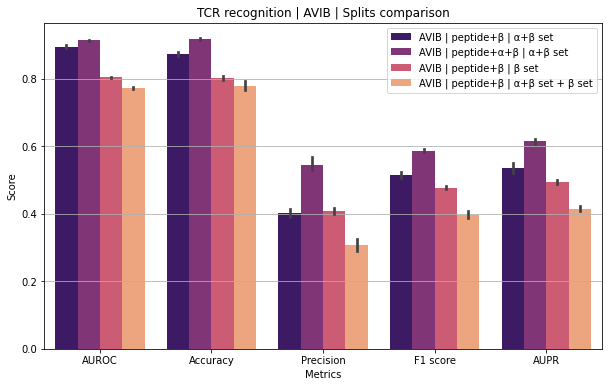

In [9]:
import seaborn as sns
import matplotlib.pyplot as plt


results = []

for i in tqdm(range(5)):
    for predictions_file in predictions_files:
        prediction_df = predictions_file[1][i]
        if f'prediction_{i}' in prediction_df.columns:
            if "LUPI-SVM" in predictions_file[0]:
                scores_df = get_scores(
                    y_true=prediction_df['sign'].to_numpy(), 
                    y_prob=sigmoid(prediction_df[f'prediction_{i}'].to_numpy()),
                    y_pred=np.sign(prediction_df[f'prediction_{i}'].to_numpy().round()).clip(min=0),
                )
            else:
                scores_df = get_scores(
                    y_true=prediction_df['sign'].to_numpy(), 
                    y_prob=prediction_df[f'prediction_{i}'].to_numpy(),
                    y_pred=prediction_df[f'prediction_{i}'].to_numpy().round(),
                )
            scores_df['Model'] = predictions_file[0]
            results.append(scores_df)
        
results_df = pd.concat(results).rename(columns={'metrics': 'Metrics', 'score': 'Score'})

plt.rcParams['figure.figsize'] = [10, 6]
ax = sns.barplot(
    x="Metrics",
    y="Score", 
    hue="Model", 
    data=results_df,
    palette=sns.color_palette("magma", len(predictions_files))
)
ax.set_title('TCR recognition | AVIB | Splits comparison')
# ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax.legend(loc='best')
legend = plt.legend(frameon = 1)
frame = legend.get_frame()
frame.set_facecolor('white')
ax.grid(axis='y')

plt.savefig(FIGURES_BASE + "baseline.splits-comparison.svg", format='svg', dpi=300, bbox_inches='tight')
plt.savefig(FIGURES_BASE + "baseline.splits-comparison.png", format='png', dpi=300, bbox_inches='tight')